## Softmax回归（是分类模型）
### 分类、回归区别
分类
- 通常多输出
- 输出i是预测第i类的置信度

回归
- 单连续数值输出
- 自然区间R
- 跟真实值的区别作为损失

### 从回归到多分类——均分损失
- 对类别进行一位有效编码(One-hot)
- 使用均分误差训练
- 最大值为预测 y = argmaxi oi
- 需要更置信的识别正确类（大余量）
 oy - oi >= delta(y,i)

### Softmax和交叉熵损失
- 交叉熵常用来衡量两个概率的区别H(p,q) = $\sum_{i}-p_{i}log(q_i)$
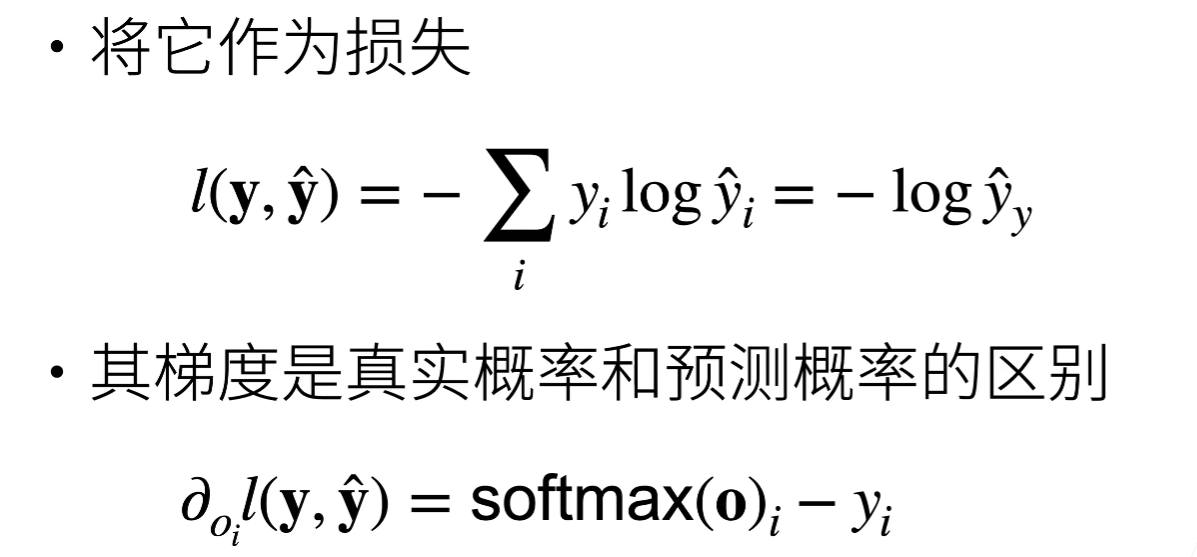

## 损失函数
- L2 Loss  l(y, y') = 1/2(y - y')^2
- L1 loss l(y, y') = |y - y'|
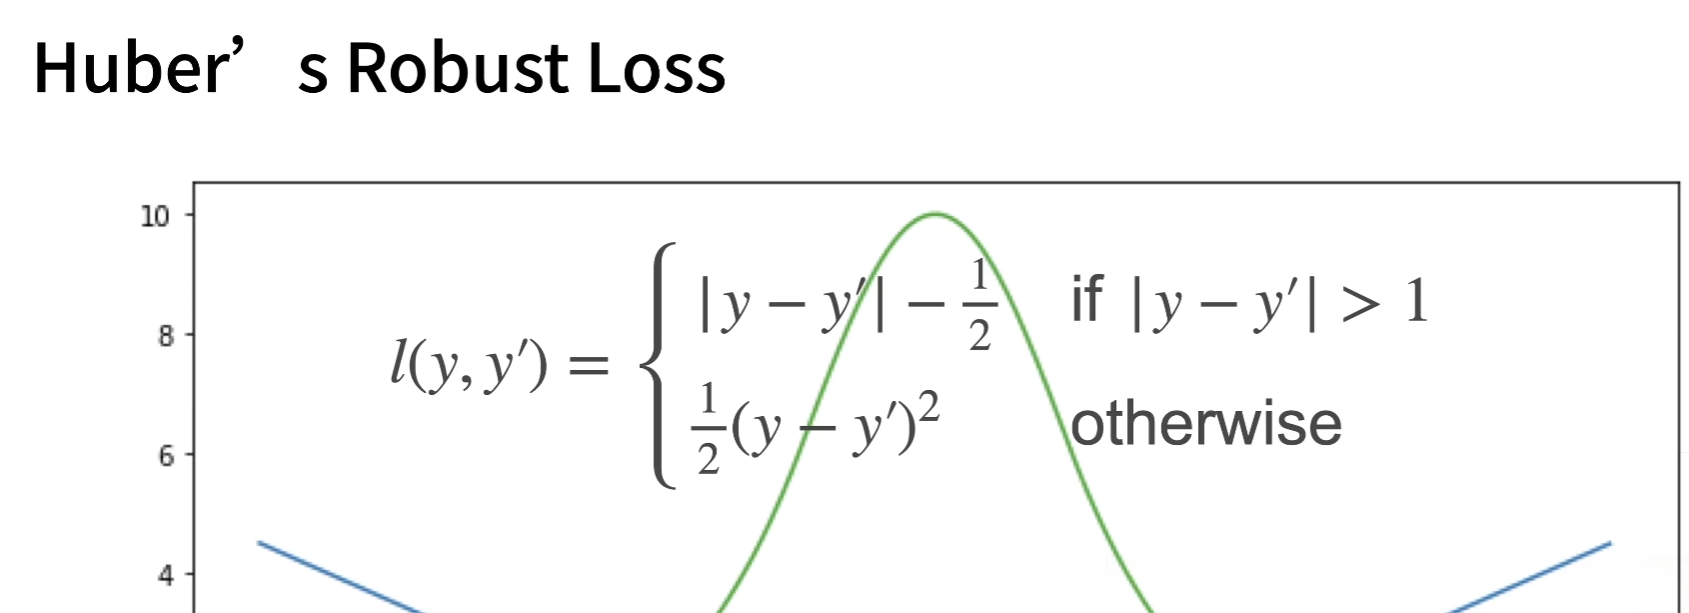


## 1 图像分类数据集
这里用Fashion-MNIST， MNIST太简单了,%是jyputer语法如内嵌matplot，！是cmd语法，如!pip

In [1]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
d2l.use_svg_display()

In [2]:
# 通过ToTensor 实例将图像数据从PIL类型转为32位浮点数格式，并除255使得数值0-1间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="data/", train=True, transform=trans, download=False)
mnist_test = torchvision.datasets.FashionMNIST(
    root="data/", train=False, transform=trans, download=False)
len(mnist_train), len(mnist_test)

(60000, 10000)

In [3]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

## 两个可视化数据集的函数

In [4]:
def get_fashion_mnist_labels(labels):
    """返回Fashion-MNIST数据集的文本数据"""
    text_labels = [
        't-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt',
        'sneaker', 'bag', 'ankle boot']
    return [text_labels_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale,  num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax ,img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)

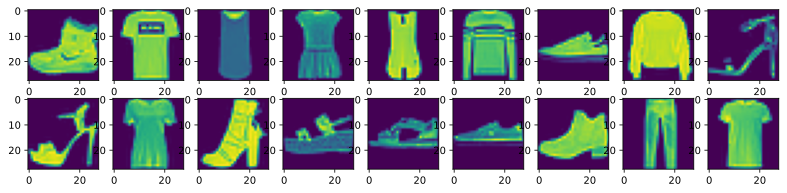

In [5]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels)

In [6]:
batch_size = 256
def get_dataloader_workers():
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers())

timer = d2l.Timer()
for X,y in train_iter:
    continue
f'{timer.stop():0.2f} sec'

'0.99 sec'

### 定义load_data_fashion_mnist函数

In [7]:
def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion_MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="data/", 
                                                    train=True, 
                                                    transform=trans, 
                                                    download=False)
    mnist_test = torchvision.datasets.FashionMNIST(root="data/",
                                                   train=False, 
                                                   transform=trans, 
                                                   download=False)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                           num_workers=get_dataloader_workers()),
           data.DataLoader(mnist_test, batch_size, shuffle=True,
                           num_workers=get_dataloader_workers()))

# 2 softmax回归的从0开始实现

In [8]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

In [9]:
# 展平每个图像为784向量，10个类别，所以输出10,此时拉伸会损失空间信息
num_inputs = 784
num_outputs = 10
w = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [10]:
# 给定一个矩阵，对所有元素求和
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5., 6.]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [11]:
# 这里X是矩阵，行一般为batchsize，列为类别树
def softmax(X):
    X_exp = torch.exp(X)
    partion = X_exp.sum(1, keepdim=True)
    return X_exp / partion # 这样应用了广播机制

In [12]:
# 将每个元素变成一个非负数，此外根据概率原理，每行总和为1，如下
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.3808, 0.2373, 0.0779, 0.1503, 0.1537],
         [0.0921, 0.3841, 0.4214, 0.0329, 0.0695]]),
 tensor([1.0000, 1.0000]))

## 实现softmax回归模型

In [13]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, w.shape[0])), w) + b)

In [14]:
# 创建一个数据y_hat,其中包含2个样本在3个类别上的预测概率，使用y作为h_hat中概率索引
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [15]:
# 实现交叉熵损失函数
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [16]:
# 求准确率
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

accuracy(y_hat, y) / len(y)

0.5

In [17]:
# 评估在任意模型net的准确率

class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n
    
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        
    def reset(self):
        self.data = [0.0] * len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
def evaluate_accuracy(net, date_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2) # 正确预测数、预测总数
    for X, y in train_iter:
        metric.add(accuracy(net(X), y), y.numel())
    
    return metric[0] / metric[1]



In [18]:
evaluate_accuracy(net, test_iter)

0.1323

## Softmax回归的训练

In [19]:
def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(
            float(l) * len(y), accuracy(y_hat, y), y.size.numel())
        else:
            # 自己实现的updater是个向量
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

### 动画类

In [20]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


In [21]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                       legend=['train loss', 'train acc', 'test acc'])
    
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc, ))
    train_loss, train_acc = train_metrics

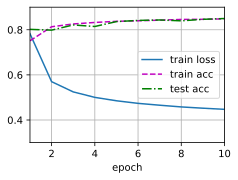

In [22]:
# mini-batch sgd来优化模型的损失函数
lr = 0.1
def updater(batch_size):
    return d2l.sgd([w, b], lr, batch_size)

num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

对图像进行分类预测

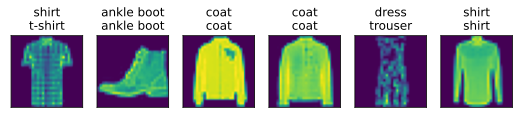

In [23]:
def predict_ch3(net, test_iter, n=6):
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])
    
predict_ch3(net, test_iter)

# softmax 回归的简洁实现
softmax 回归的输出层是一个全连接层

In [24]:
import torch
from torch import nn
from d2l import torch as d2l
batch_size = 256

In [25]:
# PyTorch不会隐式地调整输入的形状
# 因此，我们定义展平层（flatten），在线性层前调整
# Flatten()， 后
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

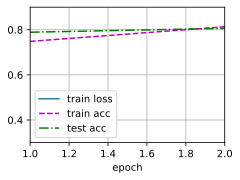

In [26]:
# 在CE损失函数中传递未归一化的预测，并同时计算softmax及其对数
loss = nn.CrossEntropyLoss()
# lr为0,1 的mini batch sgd
trainer = torch.optim.SGD(net.parameters(), lr=0.1)
num_eo = 2
d2l.train_ch3(net, train_iter, test_iter, loss, num_eo, trainer)